## House Prices Prediction

### In this tutorial we will prepare a dataset with houses characteristics and selling prices and train a regression model for sales price prediction.

#### The dataset to be used is the [Ames Housing Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) from Kaggle, which has variables describing (almost) every aspect of residential homes in Ames, Iowa.

#### Usually in a problem like this, one would explore the data and apply a fair amount of feature engineering to construct a training dataset for some more traditional multivariate regression algorithm. But here we will use a different approach, based on a Deep Neural Network that tries to learn good feature representations while being trained for the regression problem. We call this an end-to-end approach.

#### For that, we are going to apply a technique known as [Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/), also known as "Structured Deep Learning". The main idea here is to represent categorical variables in a (dense) [embedding space](https://en.wikipedia.org/wiki/Embedding), instead of the usual [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot). This embedding space is usually parameterized by a weight matrix, which in our case will be learned end-to-end with the regression problem.

#### In a Deep Learning setup, this allows a model to learn useful concepts and relations between features. For a toy example, suppose you have a variable representing day-of-week.

#### For the values "Sunday", "Monday", and "Tuesday" there would be an one-hot-encodding representation like this:
| day     | b1 | b2 | b3 | b4 | b5 | b6 | b7 |
|---------|----|----|----|----|----|----|----|
| Sunday  | 1  | 0  | 0  | 0  | 0  | 0  | 0  |
| Monday  | 0  | 1  | 0  | 0  | 0  | 0  | 0  |
| Tuesday | 0  | 0  | 1  | 0  | 0  | 0  | 0  |

#### Now suppose you train an embedding layer of size 3 for this variable, end-to-end. Your model could then learn something like this:
| day     | e1  | e2  | e3  | e4  |
|---------|-----|-----|-----|-----|
| Sunday  | 0.8 | 0.2 | 0.1 | 0.1 |
| Monday  | 0.1 | 0.2 | 0.9 | 0.9 |
| Tuesday | 0.2 | 0.1 | 0.9 | 0.8 |

#### Notice that while the one-hot encoding representation does not capture anything interesting about the data, the learned embeddings might capture a useful concept like being a weekday or not. In the example above, we see that the vectors representing Monday and Tuesday are closer to each other than the vector representing Sunday, and the first dimension of the embedding vector could represent that concept of a weekday.

#### We will begin by analyzing the dataset and performing a very basic preparation, like dealing with missing values and correcting data types for the variables. We then will construct and train a deep neural network for regression, using the [PyTorch](https://pytorch.org/) framework, that learns to predict house prices.

#### The purpose of this notebook is to explain the concepts described here in a more friendly manner. We will then perform the same training process defined here in the cloud, in a scalable manner using a cluster of GPUs and show the power of the Hyperdrive functionality of Azure Machine Learning service for hyperparameter tuning.

#### <font color='red'> Before you begin: please download the training dataset from Kaggle and save it into the "data" folder as "train.csv". You will need to login into Kaggle to be able to download the dataset. </font>

#### We begin by importing the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### We then load the dataset into a Pandas data frame, visualize the first 10 rows, and print the total number of rows and columns. We notice that this dataset has 1460 rows and 81 columns. Our response variable is the column named "SalePrice".

In [2]:
df_housing = pd.read_csv("./data/train.csv")

In [3]:
df_housing.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [4]:
df_housing.shape

(1460, 81)

#### We drop the "Id" column, because it will not help to predict the price. Then we describe all columns and notice several things:
#### - the majority of the variables are categorical
#### - some categorical variables are wrongly encoded as numerical
#### - some numerical variables are wrongly encoded as categorical
#### - there are several missing values

In [5]:
df_housing.drop("Id", axis = 1, inplace = True)

In [6]:
df_housing.describe(include = "all")

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,

In [7]:
df_housing.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

#### We begin by treating the missing values. To better analyze this ,we construct a table with the missing ratio for each variable that has missing values.

In [8]:
df_housing_missing = (df_housing.isnull().sum() / len(df_housing)) * 100
df_housing_missing = df_housing_missing.drop(df_housing_missing[df_housing_missing == 0].index).sort_values(ascending=False)

display(pd.DataFrame({'Missing Ratio' :df_housing_missing}))

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


#### Here we apply some strategies for inputting missing values, according to some hints we can get from the dataset description. For example, for some categorical variables a missing value represents a category like "None", and for some numerical variables it represents the value 0.

In [9]:
fill_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
            "BsmtExposure", "BsmtCond", "BsmtQual", "MasVnrType"]
for var in fill_none:
    df_housing[var] = df_housing[var].fillna("None")
    
fill_zero = ["GarageYrBlt", "BsmtFinType2", "BsmtFinType1", "MasVnrArea"]
for var in fill_zero:
    df_housing[var] = df_housing[var].fillna(0)

df_housing["LotFrontage"] = df_housing.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

df_housing['Electrical'] = df_housing['Electrical'].fillna(df_housing['Electrical'].mode()[0])

In [10]:
df_housing_missing = (df_housing.isnull().sum() / len(df_housing)) * 100
df_housing_missing = df_housing_missing.drop(df_housing_missing[df_housing_missing == 0].index).sort_values(ascending=False)

display(pd.DataFrame({'Missing Ratio' :df_housing_missing}))

,Missing Ratio


#### Now we correct some data types, according to our interpretation of numerical and categorical variables in this dataset. We represent numerical values as float numbers and categorical as strings.

In [11]:
numeric_vars = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF",
               "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch",
               "ScreenPorch", "PoolArea", "MiscVal", "SalePrice"]

categorical_vars = [v for v in df_housing.columns if v not in numeric_vars]

In [12]:
df_housing[numeric_vars] = df_housing[numeric_vars].astype(float)
df_housing[categorical_vars] = df_housing[categorical_vars].astype(str)

display(pd.DataFrame({"Data Type" :df_housing.dtypes}))

,Data Type
MSSubClass,object
MSZoning,object
LotFrontage,float64
LotArea,float64
Street,object
Alley,object
LotShape,object
LandContour,object
Utilities,object
LotConfig,object


#### After finishing the data preparation, we then separate the original data frame into 3: one with the numerical variables, one with the categorical variables, and one with only the response variable. This will facilitate inputting data into the neural network for training, as will be explained later.

In [13]:
response = ["SalePrice"]

df_housing_numeric = df_housing[[var for var in numeric_vars if var not in response]]
df_housing_categotical = df_housing[categorical_vars]
df_housing_response = df_housing[response]

In [14]:
df_housing_numeric.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.199658,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041
std,22.431902,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


In [15]:
df_housing_categotical.describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,3,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,4,5,6,5,5,5,7,7,6,5,2,5,4,3,4,3,8,4,4,12,7,4,6,7,98,4,5,6,6,3,4,5,5,12,5,9,6
top,20,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,2006,1950,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,3,1,TA,6,Typ,0,None,Attchd,0.0,Unf,2,TA,TA,Y,None,None,None,6,2009,WD,Normal
freq,536,1151,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,397,821,67,178,1141,1434,515,504,872,906,1282,647,649,1311,953,430,1256,1428,741,1365,1335,856,1378,768,913,804,1392,735,402,1360,690,690,870,81,605,824,1311,1326,1340,1453,1179,1406,253,338,1267,1198


In [16]:
df_housing_response.describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


#### The only thing remaining is to create an initial representation for the categorical variables. With PyTorch, we can represent these as label-encoded. In this case, labels are just indices to map a given value between its initial categorical representation and the corresponding embedding representation.

In [17]:
label_encoders = {}
for var in categorical_vars:
    label_encoders[var] = LabelEncoder()
    df_housing_categotical[var] = label_encoders[var].fit_transform(df_housing_categotical[var])

In [18]:
df_housing_categotical.describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.214384,3.028767,0.995890,0.993836,1.942466,2.777397,0.000685,3.019178,0.062329,12.251370,2.031507,2.008219,0.493151,3.038356,5.986986,4.575342,72.975342,34.865753,1.410274,1.075342,9.624658,10.339726,1.762329,2.539726,3.733562,1.396575,2.724658,3.691096,2.310274,3.637671,5.559589,1.036301,1.538356,0.934932,3.682192,0.425342,0.057534,1.565068,0.382877,2.865753,1.046575,2.339726,7.884247,5.749315,0.613014,3.087671,2.485616,62.097945,1.876712,1.767123,4.716438,4.763014,1.856164,2.991096,3.504795,1.069178,6.492466,1.815753,7.513014,3.770548
std,3.543318,0.632017,0.063996,0.249667,1.409156,0.707666,0.026171,1.622634,0.276232,6.013735,0.868515,0.259040,1.198277,1.911305,1.431256,1.112799,28.852359,20.645407,0.834998,0.599127,3.197659,3.540570,0.614274,0.693995,0.731807,0.722394,1.278630,0.949616,1.165663,1.895727,1.296332,0.295124,1.739524,0.246731,1.051301,0.518911,0.238753,0.550916,0.502885,0.811875,0.220338,0.830161,2.170814,0.979659,0.644666,1.167523,1.933206,27.910915,1.191646,0.747315,0.898787,0.802670,0.496592,0.140703,1.082912,0.372102,2.975444,1.328095,1.552100,1.100854
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,1.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,7.000000,2.000000,2.000000,0.000000,2.000000,5.000000,4.000000,55.000000,17.000000,1.000000,1.000000,8.000000,8.000000,1.000000,2.000000,4.000000,1.000000,2.000000,4.000000,2.000000,2.000000,6.000000,1.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,7.000000,6.000000,0.000000,2.000000,1.000000,45.000000,1.000000,1.000000,5.000000,5.000000,2.000000,3.000000,4.000000,1.000000,5.000000,1.000000,8.000000,4.000000
50%,5.000000,3.000000,1.000000,1.000000,3.000000,3.000000,0.000000,4.000000,0.000000,12.000000,2.000000,2.000000,0.000000,2.000000,6.000000,4.000000,74.000000,44.000000,1.000000,1.000000,12.000000,13.000000,2.000000,3.000000,4.000000,1.000000,2.000000,4.000000,3.000000,3.000000,6.000000,1.000000,0.000000,1.000000,4.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,3.000000,8.000000,6.000000,1.000000,3.000000,1.000000,64.000000,2.00

#### Now we split our prepared dataset into training, validation, and test sets. We will use 80% of the data for training, 10% for validation, and 10% for testing.

In [19]:
idx = list(range(df_housing_response.shape[0]))

np.random.seed(123)
np.random.shuffle(idx)

train_idx = idx[0:round(len(idx)*0.8)]
test_idx = idx[round(len(idx)*0.8):round(len(idx)*0.9)]
val_idx = idx[round(len(idx)*0.9):]

In [20]:
df_housing_num_train = df_housing_numeric.iloc[train_idx]
df_housing_cat_train = df_housing_categotical.iloc[train_idx]
df_housing_resp_train = df_housing_response.iloc[train_idx]

df_housing_num_test = df_housing_numeric.iloc[test_idx]
df_housing_cat_test = df_housing_categotical.iloc[test_idx]
df_housing_resp_test = df_housing_response.iloc[test_idx]

df_housing_num_val = df_housing_numeric.iloc[val_idx]
df_housing_cat_val = df_housing_categotical.iloc[val_idx]
df_housing_resp_val = df_housing_response.iloc[val_idx]

#### Thie function below is a generator for mini batches. In the training loop we define later, for each iteration we feed the neural network with a certain number of records from the training data given by the mini batch size we define. When creating a mini batch for the numerical variables, we also normalize then to help with the training convergence.

In [21]:
def get_batch(data_num, data_cat, data_resp, mb_size, scale_num):
    array_num = data_num.values.astype(np.float32)
    if scale_num:
        scaler = Normalizer()
        scaler.fit(array_num)
        array_num = scaler.transform(array_num)
    array_cat = data_cat.values.astype(np.long)
    array_resp = data_resp.values.astype(np.float32)
    shuffle = np.random.permutation(len(data_resp))
    start = 0
    array_num = array_num[shuffle]
    array_cat = array_cat[shuffle]
    array_resp = array_resp[shuffle]
    while start + mb_size <= len(data_resp):
        yield array_num[start:start+mb_size], array_cat[start:start+mb_size], array_resp[start:start+mb_size]
        start += mb_size

#### Here we define our model hypeparameters, which are used in the architecture and training process of our neural network.

In [22]:
numeric_vars = [var for var in numeric_vars if var not in response]

In [23]:
cat_dims = [int(df_housing_categotical[var].nunique()) for var in categorical_vars]
emb_dims = [min(50, (x + 1) // 2) for x in cat_dims]
hidden_layers = [512]
drop_rates = [0.25,0.25]
learning_rate = 0.005
lr_steps = [250]
lr_gamma = 0.1
mb_size = 32
num_iter = 250

#### Just to give us an idea of how each categorical variable is mapped to its corresponding embedding, here we print the size of each categorical variable and the corresponding size in the embedding space.

In [24]:
print(cat_dims, "\n\n", emb_dims)

[15, 5, 2, 3, 4, 4, 2, 5, 3, 25, 9, 8, 5, 8, 10, 9, 112, 61, 6, 8, 15, 16, 4, 4, 5, 6, 5, 5, 5, 7, 7, 6, 5, 2, 5, 4, 3, 4, 3, 8, 4, 4, 12, 7, 4, 6, 7, 98, 4, 5, 6, 6, 3, 4, 5, 5, 12, 5, 9, 6] 

 [8, 3, 1, 2, 2, 2, 1, 3, 2, 13, 5, 4, 3, 4, 5, 5, 50, 31, 3, 4, 8, 8, 2, 2, 3, 3, 3, 3, 3, 4, 4, 3, 3, 1, 3, 2, 2, 2, 2, 4, 2, 2, 6, 4, 2, 3, 4, 49, 2, 3, 3, 3, 2, 2, 3, 3, 6, 3, 5, 3]


#### This is the class defining the neural network architecture.

#### We will implement the architecture described [here](https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/), but slightly modified because we will begin training locally with one hidden layer only. The architecture implemented here is illustrated by the following diagram:

![model architecture](model_architecture.png)

#### Notice that we can easily introduce more hidden layers, just modifying the definition of the hyperparameter "hidden_layers" above.

In [25]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.embeddings = nn.ModuleList()
        for i in range(len(categorical_vars)):
            self.embeddings.append(nn.Embedding(cat_dims[i], emb_dims[i]))
        
        self.cat_dropout = nn.Dropout(drop_rates[0])
        
        self.num_batchnorm = nn.BatchNorm1d(len(numeric_vars))
        
        self.dense_block = nn.ModuleList()
        for l in range(len(hidden_layers)):
            if l == 0:
                self.dense_block.append(nn.Linear(sum(emb_dims)+len(numeric_vars), hidden_layers[l]))
                self.dense_block.append(nn.ReLU6())
                self.dense_block.append(nn.BatchNorm1d(hidden_layers[l]))
                self.dense_block.append(nn.Dropout(drop_rates[1]))
            if l > 0:
                self.dense_block.append(nn.Linear(hidden_layers[l-1], hidden_layers[l]))
                self.dense_block.append(nn.ReLU6())
                self.dense_block.append(nn.BatchNorm1d(hidden_layers[l]))
                self.dense_block.append(nn.Dropout(drop_rates[1]))
        
        self.dense = nn.Sequential(*self.dense_block)
        
        self.output = nn.Linear(hidden_layers[-1], 1)

    def forward(self, Xc_list, Xn):
        Xc_list = [self.embeddings[i](Xc_list[i]) for i in range(len(Xc_list))]
        Xc = torch.cat(Xc_list, dim=1)
        Xc = self.cat_dropout(Xc)
        Xn = self.num_batchnorm(Xn)
        X = torch.cat([Xc, Xn], dim=1)
        X = self.dense(X)
        X = self.output(X)
        return X

#### The loss function to be use here is the MAE (Mean Absolute Error).

In [26]:
class MAE_Loss(nn.Module):
    def __init__(self):
        super(MAE_Loss, self).__init__()
    
    def forward(self, X, Y):
        error = torch.abs(Y - X)
        loss = torch.mean(error)
        return loss

#### We then instantiate our model object and print the number of learnable parameters. We also define a flag, which indicates if there is a GPU available for training. If so, we can send our model object and all PyTorch tensors to be processed on the GPU.

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
gpu_available = torch.cuda.is_available()
print(gpu_available)

False


In [29]:
model = Model().cuda() if gpu_available else Model()
print("Number of learnable parameters: %d" % count_parameters(model))
# print(model)

Number of learnable parameters: 192727


#### Here we define aour model loss object, which we will try to minimize during training. We also define the optimizer and scheduler objects for the training process. Here we will use the Adam Optimization algorithm.

In [30]:
model_loss = MAE_Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_steps, gamma=lr_gamma)

#### And finally we define the main training loop. We will iterate several times (also known as epochs) through the entire training data, performing forward and backward passes (known as backpropagation) through the network in order to minimize the loss function.

#### For each of those iterations, we split the data into mini batches to perform the forward and backward passes, also keeping track of the model performance on the validation data.

In [31]:
train_losses = []
val_losses = []
num_mb = int(len(df_housing_num_train)/mb_size)

for n in range(num_iter):
    train_loss = 0
    val_loss = 0
    
    for k, (mb_Xn, mb_Xc, mb_Y) in enumerate(get_batch(df_housing_num_train, df_housing_cat_train, df_housing_resp_train, mb_size, True)):
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # convert data from numpy arrays to torch tensors and put them on GPU, if we have one available
        mb_Xn = torch.from_numpy(mb_Xn).cuda() if gpu_available else torch.from_numpy(mb_Xn)
        mb_Xc = [torch.from_numpy(mb_Xc[:,i]).long().cuda() if gpu_available else torch.from_numpy(mb_Xc[:,i]).long() for i in range(len(categorical_vars))]
        mb_Y = torch.from_numpy(mb_Y).cuda() if gpu_available else torch.from_numpy(mb_Y)
        
        # run forward + backward + optimize on a mini-batch
        outputs = model(mb_Xc, mb_Xn)
        loss = model_loss(outputs, mb_Y)
        loss.backward()
        optimizer.step()
        
        # update cost for each iteration
        train_loss += loss.data / num_mb
    
    # print and save the cost for each itaration
    print ("Train loss after itaration %i: %f" % (n, train_loss))
    train_losses.append(train_loss.cpu())
    
    # print actual and predicted values
    with torch.no_grad():
        model.eval()
        
        for k, (mb_Xn, mb_Xc, mb_Y) in enumerate(get_batch(df_housing_num_val, df_housing_cat_val, df_housing_resp_val, mb_size, True)):
            mb_Xn = torch.from_numpy(mb_Xn).cuda() if gpu_available else torch.from_numpy(mb_Xn)
            mb_Xc = [torch.from_numpy(mb_Xc[:,i]).long().cuda() if gpu_available else torch.from_numpy(mb_Xc[:,i]).long() for i in range(len(categorical_vars))]
            mb_Y = torch.from_numpy(mb_Y).cuda() if gpu_available else torch.from_numpy(mb_Y)
            outputs = model(mb_Xc, mb_Xn)
            loss = model_loss(outputs, mb_Y)
            val_loss += loss.data / num_mb
        print ("Validation loss after itaration %i: %f" % (n, val_loss))
        val_losses.append(val_loss.cpu())
        
        idx = np.random.choice(range(mb_size))
        actual = mb_Y[idx]
        Xc = [mb_Xc[i][idx].view(1) for i in range(len(categorical_vars))]
        Xn = mb_Xn[idx].view(1,len(numeric_vars))
        predicted = model(Xc, Xn)
        actual = actual.cpu().numpy().flatten()
        predicted = predicted.cpu().numpy().flatten()
        print("Actual: %s\tPredicted (Validation): %s\tError (Validation): %s\n\n" % (str(actual), str(predicted), str(np.abs(actual - predicted))))
        
        model.train()
        
    scheduler.step()

Train loss after itaration 0: 180999.265625
Validation loss after itaration 0: 19959.140625
Actual: [109500.]	Predicted (Validation): [16.882086]	Error (Validation): [109483.12]


Train loss after itaration 1: 181147.015625
Validation loss after itaration 1: 20260.265625
Actual: [119000.]	Predicted (Validation): [102.96387]	Error (Validation): [118897.04]


Train loss after itaration 2: 181078.953125
Validation loss after itaration 2: 20330.298828
Actual: [386250.]	Predicted (Validation): [263.2044]	Error (Validation): [385986.78]


Train loss after itaration 3: 180584.781250
Validation loss after itaration 3: 20472.478516
Actual: [153500.]	Predicted (Validation): [531.44794]	Error (Validation): [152968.55]


Train loss after itaration 4: 180655.781250
Validation loss after itaration 4: 20541.111328
Actual: [147000.]	Predicted (Validation): [909.31696]	Error (Validation): [146090.69]


Train loss after itaration 5: 180175.125000
Validation loss after itaration 5: 20534.773438
Actual: [

Train loss after itaration 46: 98430.867188
Validation loss after itaration 46: 10886.616211
Actual: [129000.]	Predicted (Validation): [85509.51]	Error (Validation): [43490.492]


Train loss after itaration 47: 95254.429688
Validation loss after itaration 47: 11141.875000
Actual: [337000.]	Predicted (Validation): [89182.21]	Error (Validation): [247817.78]


Train loss after itaration 48: 92280.445312
Validation loss after itaration 48: 10533.266602
Actual: [134432.]	Predicted (Validation): [91733.766]	Error (Validation): [42698.234]


Train loss after itaration 49: 89386.343750
Validation loss after itaration 49: 9896.232422
Actual: [280000.]	Predicted (Validation): [95732.08]	Error (Validation): [184267.92]


Train loss after itaration 50: 86214.726562
Validation loss after itaration 50: 9535.975586
Actual: [197000.]	Predicted (Validation): [99602.22]	Error (Validation): [97397.78]


Train loss after itaration 51: 82673.679688
Validation loss after itaration 51: 9396.081055
Actual: [3

Train loss after itaration 92: 19867.560547
Validation loss after itaration 92: 2606.932373
Actual: [239500.]	Predicted (Validation): [231799.11]	Error (Validation): [7700.8906]


Train loss after itaration 93: 20291.132812
Validation loss after itaration 93: 2738.432861
Actual: [154900.]	Predicted (Validation): [129078.336]	Error (Validation): [25821.664]


Train loss after itaration 94: 20489.218750
Validation loss after itaration 94: 2338.747070
Actual: [127000.]	Predicted (Validation): [125028.586]	Error (Validation): [1971.4141]


Train loss after itaration 95: 20651.960938
Validation loss after itaration 95: 2506.997559
Actual: [189000.]	Predicted (Validation): [188385.47]	Error (Validation): [614.53125]


Train loss after itaration 96: 20149.601562
Validation loss after itaration 96: 2578.116211
Actual: [438780.]	Predicted (Validation): [298270.66]	Error (Validation): [140509.34]


Train loss after itaration 97: 19675.792969
Validation loss after itaration 97: 2634.556396
Actual

Train loss after itaration 138: 16140.400391
Validation loss after itaration 138: 2203.740967
Actual: [91000.]	Predicted (Validation): [113293.24]	Error (Validation): [22293.242]


Train loss after itaration 139: 16186.152344
Validation loss after itaration 139: 2200.934082
Actual: [131000.]	Predicted (Validation): [137970.06]	Error (Validation): [6970.0625]


Train loss after itaration 140: 17650.960938
Validation loss after itaration 140: 2083.068848
Actual: [239500.]	Predicted (Validation): [233230.02]	Error (Validation): [6269.9844]


Train loss after itaration 141: 16051.290039
Validation loss after itaration 141: 2357.788330
Actual: [197900.]	Predicted (Validation): [166473.94]	Error (Validation): [31426.062]


Train loss after itaration 142: 16599.855469
Validation loss after itaration 142: 2252.575684
Actual: [213000.]	Predicted (Validation): [195162.73]	Error (Validation): [17837.266]


Train loss after itaration 143: 16306.290039
Validation loss after itaration 143: 2314.3916

Train loss after itaration 184: 16752.927734
Validation loss after itaration 184: 2056.137695
Actual: [139000.]	Predicted (Validation): [132033.25]	Error (Validation): [6966.75]


Train loss after itaration 185: 14573.354492
Validation loss after itaration 185: 2119.401855
Actual: [272000.]	Predicted (Validation): [212708.06]	Error (Validation): [59291.938]


Train loss after itaration 186: 15676.001953
Validation loss after itaration 186: 2002.214355
Actual: [119000.]	Predicted (Validation): [120761.945]	Error (Validation): [1761.9453]


Train loss after itaration 187: 14931.164062
Validation loss after itaration 187: 2150.877197
Actual: [139000.]	Predicted (Validation): [109598.12]	Error (Validation): [29401.883]


Train loss after itaration 188: 15767.226562
Validation loss after itaration 188: 2184.781250
Actual: [213000.]	Predicted (Validation): [195638.81]	Error (Validation): [17361.188]


Train loss after itaration 189: 14646.892578
Validation loss after itaration 189: 1997.8208

Train loss after itaration 230: 14052.542969
Validation loss after itaration 230: 2142.046143
Actual: [153500.]	Predicted (Validation): [107736.484]	Error (Validation): [45763.516]


Train loss after itaration 231: 15148.971680
Validation loss after itaration 231: 1950.165649
Actual: [82000.]	Predicted (Validation): [97193.98]	Error (Validation): [15193.977]


Train loss after itaration 232: 15415.201172
Validation loss after itaration 232: 2070.210449
Actual: [132500.]	Predicted (Validation): [136427.4]	Error (Validation): [3927.4062]


Train loss after itaration 233: 16521.851562
Validation loss after itaration 233: 1802.998291
Actual: [128500.]	Predicted (Validation): [127600.47]	Error (Validation): [899.53125]


Train loss after itaration 234: 15816.149414
Validation loss after itaration 234: 2050.202148
Actual: [100000.]	Predicted (Validation): [117821.94]	Error (Validation): [17821.938]


Train loss after itaration 235: 17226.937500
Validation loss after itaration 235: 2100.76440

#### After finishing training, we save the learned model parameters to disk. We also save the data points of the losses for training and validation that were collected during the training loop.

In [32]:
torch.save(model.state_dict(), './model/housing_model_state_dict.pt')

pickle.dump(train_losses, open('./model/housing_train_losses.pickle', 'wb'))
pickle.dump(val_losses, open('./model/housing_val_losses.pickle', 'wb'))

#### Here we load the data and plot the losses computed for the training and validation data during the training process.

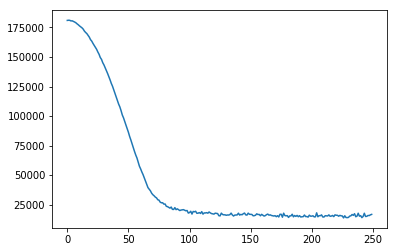

In [33]:
train_losses = pickle.load(open('./model/housing_train_losses.pickle', "rb"))

plt.figure()
plt.plot(train_losses)

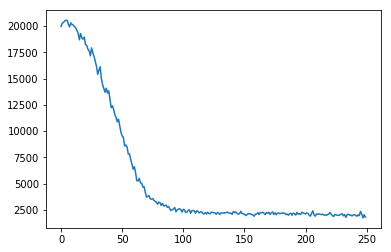

In [34]:
val_losses = pickle.load(open('./model/housing_val_losses.pickle', "rb"))

plt.figure()
plt.plot(val_losses)

#### As the final step, we define a function to compute the MAE and print the corresponding results for the training, validation, and test sets.

In [35]:
def MAE(data_num, data_cat, data_resp):
    with torch.no_grad():
        errors = []
        for k, (mb_Xn, mb_Xc, mb_Y) in enumerate(get_batch(data_num, data_cat, data_resp, mb_size, True)):
            Xn = torch.from_numpy(mb_Xn).cuda() if gpu_available else torch.from_numpy(mb_Xn)
            Xc = [torch.from_numpy(mb_Xc[:,i]).long().cuda() if gpu_available else torch.from_numpy(mb_Xc[:,i]).long() for i in range(len(categorical_vars))]
            actual = torch.from_numpy(mb_Y).cuda() if gpu_available else torch.from_numpy(mb_Y)
            predicted = model(Xc, Xn)
            actual = actual.cpu().numpy().flatten()
            predicted = predicted.cpu().numpy().flatten()
            errors.append(np.abs(actual - predicted))
        return np.mean(errors)

In [36]:
model.load_state_dict(torch.load('./model/housing_model_state_dict.pt', map_location='cpu'))

model.eval()

print("MAE (Train): %f" % MAE(df_housing_num_train, df_housing_cat_train, df_housing_resp_train))
print("MAE (Validation): %f" % MAE(df_housing_num_val, df_housing_cat_val, df_housing_resp_val))
print("MAE (Test): %f" % MAE(df_housing_num_test, df_housing_cat_test, df_housing_resp_test))

MAE (Train): 6902.461426
MAE (Validation): 17743.656250
MAE (Test): 21025.816406
